# Complete Layered BERT Architecture for Shakespeare Sonnets
## Trajectory Tortuosity Analysis with Three-Layer Prosodic Conditioning

This notebook presents a complete experimental design testing how different BERT architectures
capture semantic complexity in Shakespeare's 154 sonnets.

## Experimental Design

### Models Tested:
1. **bert-base-uncased** (Baseline - general modern English)
2. **EEBO-BERT** (Layer 1 - historical semantics 1595-1700)
3. **Poetry-BERT** (Current Layer 2 - poetry specialization, trained from base)
4. **Poetry-EEBO-BERT** (Proper Layer 2 - TO BE TRAINED on Colab)

### Conditioning Tested:
- **Semantic-only**: Pure BERT embeddings (768 dimensions)
- **+Prosody** (Layer 3): Embeddings augmented with prosodic features (768 + 4 dimensions)
  - Metrical deviation from iambic pentameter
  - Rhyme pair detection (Shakespearean sonnet scheme: ABAB CDCD EFEF GG)
  - Positional encoding (line position in sonnet)
  - Couplet marking (final 2 lines)

### Research Questions:
1. Does historical training (EEBO) change semantic representations?
2. Does poetry training change semantic representations?
3. Do prosodic constraints influence semantic trajectory?
4. How do these layers interact?

### Trajectory Tortuosity Metric:
```
tortuosity = cumulative_angular_deviation / euclidean_distance
```
- Measures semantic "turns" through 768-dimensional BERT embedding space
- Higher values = more complex semantic trajectory (more directional changes)
- Lower values = smoother semantic progression

## Setup

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from pathlib import Path
import prosodic as p

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports complete")

✓ Imports complete


## Load Pre-Computed Results

Load all experimental results for comparison

In [2]:
# Load all results
results = {}

# Base BERT (includes both semantic and prosody in same file)
results['base_layer3'] = pd.read_csv('../results/shakespeare_sonnets_layer3_base_bert.csv')

# Semantic-only (no prosody)
results['eebo_semantic'] = pd.read_csv('../results/shakespeare_sonnets_eebo_bert_contextual.csv')
results['poetry_semantic'] = pd.read_csv('../results/shakespeare_sonnets_poetry_bert_contextual.csv')

# With prosody (Layer 3)
results['eebo_layer3'] = pd.read_csv('../results/shakespeare_sonnets_layer3_eebo_bert.csv')
results['poetry_layer3'] = pd.read_csv('../results/shakespeare_sonnets_layer3_poetry_bert.csv')

# Comparison
results['comparison'] = pd.read_csv('../results/eebo_vs_poetry_bert_contextual_comparison.csv')

print("✓ All results loaded")
print(f"  Base BERT (both): {len(results['base_layer3'])} sonnets")
print(f"  EEBO semantic: {len(results['eebo_semantic'])} sonnets")
print(f"  Poetry semantic: {len(results['poetry_semantic'])} sonnets")
print(f"  EEBO + prosody: {len(results['eebo_layer3'])} sonnets")
print(f"  Poetry + prosody: {len(results['poetry_layer3'])} sonnets")

✓ All results loaded
  Base BERT (both): 154 sonnets
  EEBO semantic: 154 sonnets
  Poetry semantic: 154 sonnets
  EEBO + prosody: 154 sonnets
  Poetry + prosody: 154 sonnets


## Summary Statistics

### Overall Tortuosity by Model and Conditioning

In [3]:
summary_data = []

# Base BERT
summary_data.append({
    'Model': 'Base BERT',
    'Conditioning': 'Semantic Only',
    'Mean': results['base_layer3']['semantic_tortuosity'].mean(),
    'SD': results['base_layer3']['semantic_tortuosity'].std(),
    'Min': results['base_layer3']['semantic_tortuosity'].min(),
    'Max': results['base_layer3']['semantic_tortuosity'].max()
})

summary_data.append({
    'Model': 'Base BERT',
    'Conditioning': '+ Prosody (Layer 3)',
    'Mean': results['base_layer3']['prosody_conditioned_tortuosity'].mean(),
    'SD': results['base_layer3']['prosody_conditioned_tortuosity'].std(),
    'Min': results['base_layer3']['prosody_conditioned_tortuosity'].min(),
    'Max': results['base_layer3']['prosody_conditioned_tortuosity'].max()
})

# EEBO-BERT
summary_data.append({
    'Model': 'EEBO-BERT',
    'Conditioning': 'Semantic Only',
    'Mean': results['eebo_semantic']['overall_tortuosity'].mean(),
    'SD': results['eebo_semantic']['overall_tortuosity'].std(),
    'Min': results['eebo_semantic']['overall_tortuosity'].min(),
    'Max': results['eebo_semantic']['overall_tortuosity'].max()
})

summary_data.append({
    'Model': 'EEBO-BERT',
    'Conditioning': '+ Prosody (Layer 3)',
    'Mean': results['eebo_layer3']['prosody_conditioned_tortuosity'].mean(),
    'SD': results['eebo_layer3']['prosody_conditioned_tortuosity'].std(),
    'Min': results['eebo_layer3']['prosody_conditioned_tortuosity'].min(),
    'Max': results['eebo_layer3']['prosody_conditioned_tortuosity'].max()
})

# Poetry-BERT
summary_data.append({
    'Model': 'Poetry-BERT',
    'Conditioning': 'Semantic Only',
    'Mean': results['poetry_semantic']['overall_tortuosity'].mean(),
    'SD': results['poetry_semantic']['overall_tortuosity'].std(),
    'Min': results['poetry_semantic']['overall_tortuosity'].min(),
    'Max': results['poetry_semantic']['overall_tortuosity'].max()
})

summary_data.append({
    'Model': 'Poetry-BERT',
    'Conditioning': '+ Prosody (Layer 3)',
    'Mean': results['poetry_layer3']['prosody_conditioned_tortuosity'].mean(),
    'SD': results['poetry_layer3']['prosody_conditioned_tortuosity'].std(),
    'Min': results['poetry_layer3']['prosody_conditioned_tortuosity'].min(),
    'Max': results['poetry_layer3']['prosody_conditioned_tortuosity'].max()
})

df_summary = pd.DataFrame(summary_data)

print("="*80)
print("EXPERIMENTAL RESULTS SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print("\n" + "="*80)

EXPERIMENTAL RESULTS SUMMARY
      Model        Conditioning     Mean       SD      Min      Max
  Base BERT       Semantic Only 3.170677 0.424656 2.260798 4.466694
  Base BERT + Prosody (Layer 3) 3.104944 0.398563 2.234479 4.271949
  EEBO-BERT       Semantic Only 3.446670 0.364337 2.633465 4.562865
  EEBO-BERT + Prosody (Layer 3) 3.363907 0.338117 2.598413 4.350969
Poetry-BERT       Semantic Only 3.590874 0.352124 2.584819 4.572891
Poetry-BERT + Prosody (Layer 3) 3.498416 0.327624 2.545685 4.372206



## Visualization: Model Comparison

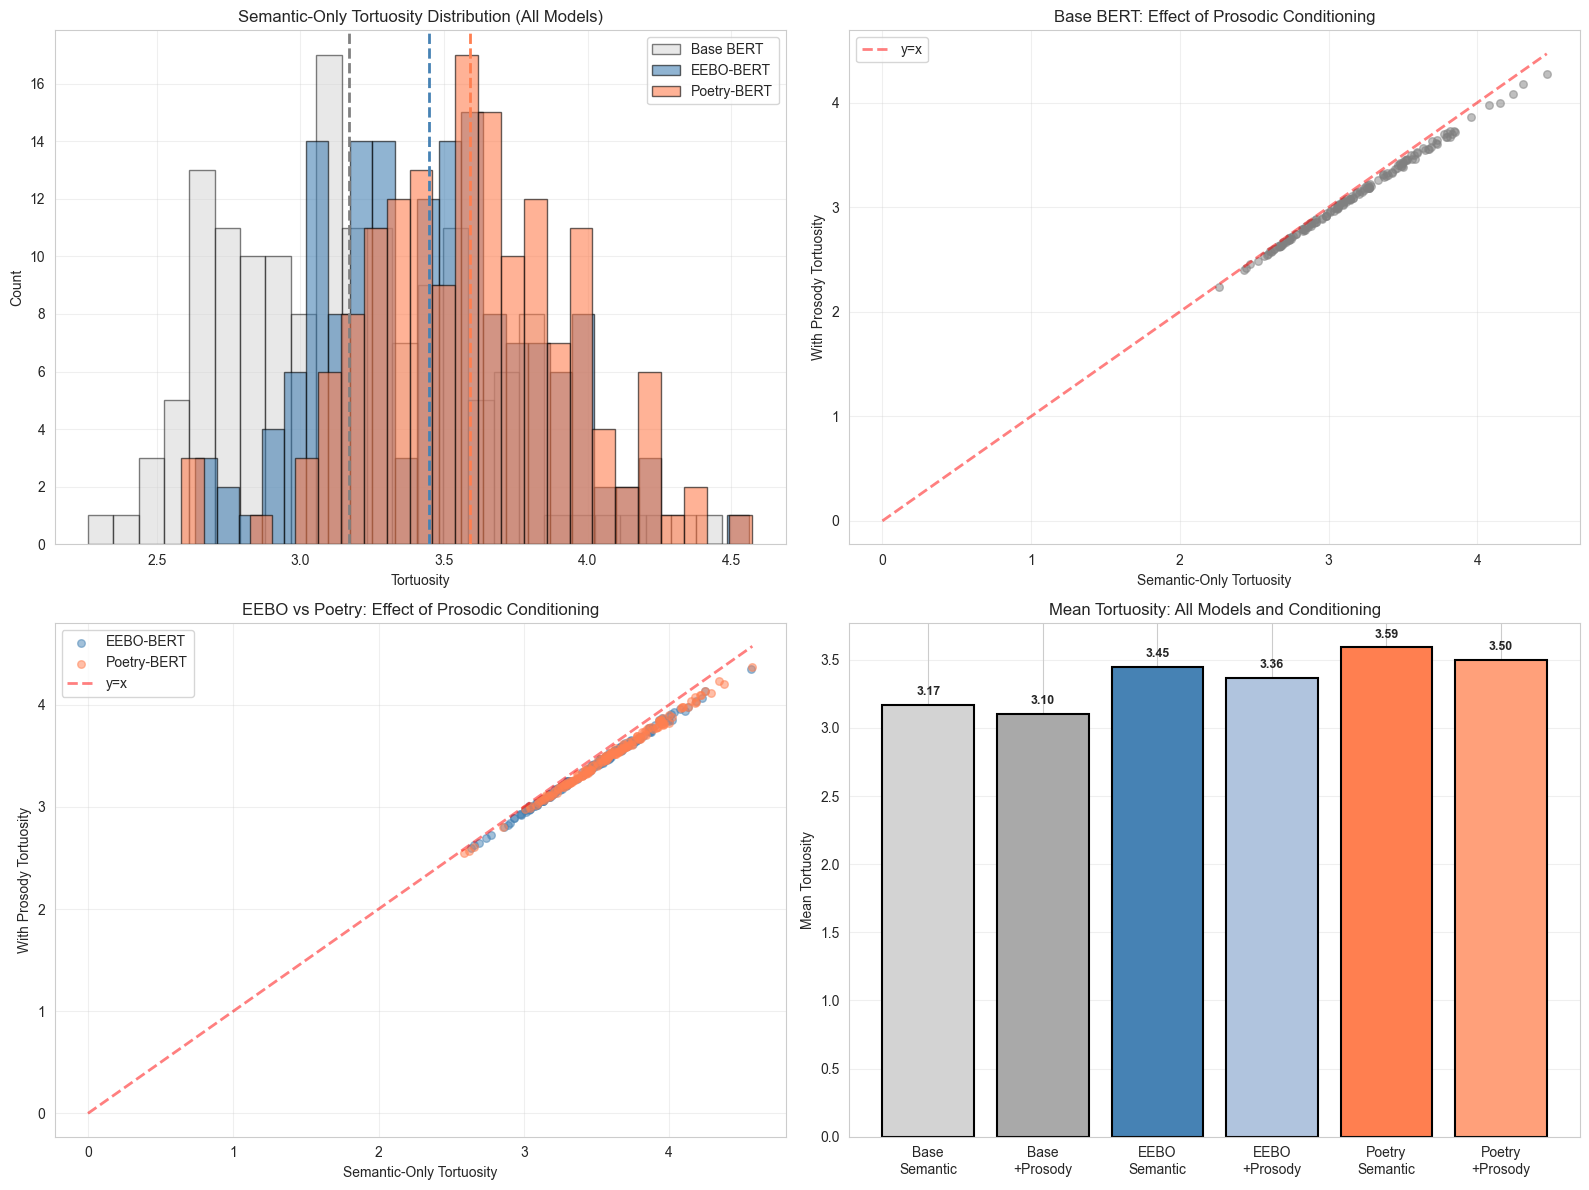

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution comparison - Semantic only (all three models)
axes[0, 0].hist(results['base_layer3']['semantic_tortuosity'], bins=25, alpha=0.5, 
               label='Base BERT', edgecolor='black', color='lightgray')
axes[0, 0].hist(results['eebo_semantic']['overall_tortuosity'], bins=25, alpha=0.6, 
               label='EEBO-BERT', edgecolor='black', color='steelblue')
axes[0, 0].hist(results['poetry_semantic']['overall_tortuosity'], bins=25, alpha=0.6,
               label='Poetry-BERT', edgecolor='black', color='coral')
axes[0, 0].axvline(results['base_layer3']['semantic_tortuosity'].mean(), 
                  color='gray', linestyle='--', linewidth=2)
axes[0, 0].axvline(results['eebo_semantic']['overall_tortuosity'].mean(), 
                  color='steelblue', linestyle='--', linewidth=2)
axes[0, 0].axvline(results['poetry_semantic']['overall_tortuosity'].mean(),
                  color='coral', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Tortuosity')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Semantic-Only Tortuosity Distribution (All Models)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Effect of prosody on Base BERT
axes[0, 1].scatter(results['base_layer3']['semantic_tortuosity'],
                  results['base_layer3']['prosody_conditioned_tortuosity'],
                  alpha=0.5, s=30, color='gray')
max_val = max(results['base_layer3']['semantic_tortuosity'].max(),
             results['base_layer3']['prosody_conditioned_tortuosity'].max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2, label='y=x')
axes[0, 1].set_xlabel('Semantic-Only Tortuosity')
axes[0, 1].set_ylabel('With Prosody Tortuosity')
axes[0, 1].set_title('Base BERT: Effect of Prosodic Conditioning')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Effect of prosody comparison across models
axes[1, 0].scatter(results['eebo_layer3']['semantic_tortuosity'],
                  results['eebo_layer3']['prosody_conditioned_tortuosity'],
                  alpha=0.5, s=30, color='steelblue', label='EEBO-BERT')
axes[1, 0].scatter(results['poetry_layer3']['semantic_tortuosity'],
                  results['poetry_layer3']['prosody_conditioned_tortuosity'],
                  alpha=0.5, s=30, color='coral', label='Poetry-BERT')
max_val = max(results['eebo_layer3']['semantic_tortuosity'].max(),
             results['poetry_layer3']['semantic_tortuosity'].max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2, label='y=x')
axes[1, 0].set_xlabel('Semantic-Only Tortuosity')
axes[1, 0].set_ylabel('With Prosody Tortuosity')
axes[1, 0].set_title('EEBO vs Poetry: Effect of Prosodic Conditioning')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Bar chart comparison - All models
models = ['Base\nSemantic', 'Base\n+Prosody', 
          'EEBO\nSemantic', 'EEBO\n+Prosody', 
          'Poetry\nSemantic', 'Poetry\n+Prosody']
means = [
    results['base_layer3']['semantic_tortuosity'].mean(),
    results['base_layer3']['prosody_conditioned_tortuosity'].mean(),
    results['eebo_semantic']['overall_tortuosity'].mean(),
    results['eebo_layer3']['prosody_conditioned_tortuosity'].mean(),
    results['poetry_semantic']['overall_tortuosity'].mean(),
    results['poetry_layer3']['prosody_conditioned_tortuosity'].mean()
]
colors = ['lightgray', 'darkgray', 'steelblue', 'lightsteelblue', 'coral', 'lightsalmon']
axes[1, 1].bar(models, means, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Mean Tortuosity')
axes[1, 1].set_title('Mean Tortuosity: All Models and Conditioning')
axes[1, 1].grid(alpha=0.3, axis='y')

# Add values on bars
for i, (model, mean) in enumerate(zip(models, means)):
    axes[1, 1].text(i, mean + 0.05, f'{mean:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## Scansion Analysis

Examine metrical patterns in sonnets with highest/lowest complexity

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive scatter plots for couplet analysis
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Base BERT', 'EEBO-BERT', 'Poetry-BERT'),
    horizontal_spacing=0.1
)

# Base BERT
fig.add_trace(
    go.Scatter(
        x=results['base_layer3']['semantic_tortuosity'],
        y=results['base_layer3']['couplet_tortuosity'] if 'couplet_tortuosity' in results['base_layer3'].columns else [0]*len(results['base_layer3']),
        mode='markers',
        marker=dict(size=8, color=results['base_layer3']['sonnet'], colorscale='Viridis', showscale=False),
        text=results['base_layer3']['sonnet'].apply(lambda x: f'Sonnet {x}'),
        hovertemplate='<b>%{text}</b><br>Mean Line: %{x:.3f}<br>Couplet: %{y:.3f}<extra></extra>',
        name='Base BERT'
    ),
    row=1, col=1
)

# EEBO-BERT
fig.add_trace(
    go.Scatter(
        x=results['eebo_semantic']['mean_line_tortuosity'],
        y=results['eebo_semantic']['couplet_tortuosity'],
        mode='markers',
        marker=dict(size=8, color=results['eebo_semantic']['sonnet'], colorscale='Viridis', showscale=False),
        text=results['eebo_semantic']['sonnet'].apply(lambda x: f'Sonnet {x}'),
        hovertemplate='<b>%{text}</b><br>Mean Line: %{x:.3f}<br>Couplet: %{y:.3f}<extra></extra>',
        name='EEBO-BERT'
    ),
    row=1, col=2
)

# Poetry-BERT
fig.add_trace(
    go.Scatter(
        x=results['poetry_semantic']['mean_line_tortuosity'],
        y=results['poetry_semantic']['couplet_tortuosity'],
        mode='markers',
        marker=dict(size=8, color=results['poetry_semantic']['sonnet'], colorscale='Viridis', showscale=True,
                   colorbar=dict(title="Sonnet", x=1.15)),
        text=results['poetry_semantic']['sonnet'].apply(lambda x: f'Sonnet {x}'),
        hovertemplate='<b>%{text}</b><br>Mean Line: %{x:.3f}<br>Couplet: %{y:.3f}<extra></extra>',
        name='Poetry-BERT'
    ),
    row=1, col=3
)

# Add y=x reference lines
for col in range(1, 4):
    if col == 1:
        max_val = max(results['base_layer3']['semantic_tortuosity'].max(), 
                     results['base_layer3']['couplet_tortuosity'].max() if 'couplet_tortuosity' in results['base_layer3'].columns else 0)
    elif col == 2:
        max_val = max(results['eebo_semantic']['mean_line_tortuosity'].max(), 
                     results['eebo_semantic']['couplet_tortuosity'].max())
    else:
        max_val = max(results['poetry_semantic']['mean_line_tortuosity'].max(), 
                     results['poetry_semantic']['couplet_tortuosity'].max())
    
    fig.add_trace(
        go.Scatter(
            x=[0, max_val],
            y=[0, max_val],
            mode='lines',
            line=dict(color='red', dash='dash', width=2),
            showlegend=False,
            hoverinfo='skip'
        ),
        row=1, col=col
    )

# Update axes
fig.update_xaxes(title_text="Mean Line Tortuosity", row=1, col=1)
fig.update_xaxes(title_text="Mean Line Tortuosity", row=1, col=2)
fig.update_xaxes(title_text="Mean Line Tortuosity", row=1, col=3)

fig.update_yaxes(title_text="Couplet Tortuosity", row=1, col=1)
fig.update_yaxes(title_text="Couplet Tortuosity", row=1, col=2)
fig.update_yaxes(title_text="Couplet Tortuosity", row=1, col=3)

fig.update_layout(
    height=500,
    title_text="Couplet Complexity vs Mean Line Complexity (Hover to identify sonnets)",
    showlegend=False
)

fig.show()

# Statistics
print("\n" + "="*80)
print("COUPLET COMPLEXITY STATISTICS")
print("="*80)

# We need to check if base_layer3 has couplet data
if 'couplet_tortuosity' in results['base_layer3'].columns:
    base_high_couplet = (results['base_layer3']['couplet_tortuosity'] > results['base_layer3']['semantic_tortuosity']).sum()
    print(f"\nBase BERT:   {base_high_couplet} sonnets ({base_high_couplet/len(results['base_layer3'])*100:.1f}%) have couplets more complex than average line")

eebo_high_couplet = (results['eebo_semantic']['couplet_tortuosity'] > results['eebo_semantic']['mean_line_tortuosity']).sum()
print(f"EEBO-BERT:   {eebo_high_couplet} sonnets ({eebo_high_couplet/len(results['eebo_semantic'])*100:.1f}%) have couplets more complex than average line")

poetry_high_couplet = (results['poetry_semantic']['couplet_tortuosity'] > results['poetry_semantic']['mean_line_tortuosity']).sum()
print(f"Poetry-BERT: {poetry_high_couplet} sonnets ({poetry_high_couplet/len(results['poetry_semantic'])*100:.1f}%) have couplets more complex than average line")

print("\nInterpretation:")
print("- Points ABOVE the red line: couplet is more complex than average line")
print("- Points BELOW the red line: couplet is less complex than average line")
print("- Hover over points to identify specific sonnets")


COUPLET COMPLEXITY STATISTICS

Base BERT:   154 sonnets (100.0%) have couplets more complex than average line
EEBO-BERT:   53 sonnets (34.4%) have couplets more complex than average line
Poetry-BERT: 58 sonnets (37.7%) have couplets more complex than average line

Interpretation:
- Points ABOVE the red line: couplet is more complex than average line
- Points BELOW the red line: couplet is less complex than average line
- Hover over points to identify specific sonnets


## Couplet Analysis

Analyze whether the final couplet (last 2 lines) is more or less complex than the average line in each sonnet.

In [6]:
# Load sonnets
sonnets_path = Path('../corpus_samples/shakespeare_sonnets_parsed.jsonl')
sonnets = []
with open(sonnets_path, 'r') as f:
    for line in f:
        sonnets.append(json.loads(line))

sonnet_lookup = {s['sonnet_number']: s for s in sonnets}
print(f"✓ Loaded {len(sonnets)} sonnets")

✓ Loaded 154 sonnets


In [7]:
def get_all_scansions(line_text):
    """
    Get all possible scansions for a line, formatted for hand-scansion style display.
    
    Returns list of dictionaries with:
        - formatted_text: HTML formatted with foot boundaries and bold stress
        - stress_pattern: String like '0101010101'
        - meter_type: Description of meter
        - deviation: Deviation from ideal iambic pentameter
    """
    try:
        parsed = p.Text(line_text).parse()
        if not parsed or len(parsed) == 0:
            return None
        
        scansions = []
        ideal_pattern = [0, 1] * 5  # Iambic pentameter
        
        # Get all possible parses (not just the best one)
        for parse_option in parsed:
            if not parse_option or len(parse_option) == 0:
                continue
                
            for parse in parse_option:
                if not hasattr(parse, 'stress_ints') or not parse.stress_ints:
                    continue
                
                stress_pattern = list(parse.stress_ints)
                
                # Build formatted text with syllables and foot boundaries
                formatted_parts = []
                syllables = []
                
                # Get syllables and their stresses
                for i, (syll, stress) in enumerate(zip(parse.syllables(), stress_pattern)):
                    syll_text = str(syll).strip()
                    if stress == 1:
                        syll_text = f"**{syll_text}**"  # Bold for stressed
                    syllables.append(syll_text)
                
                # Add foot boundaries (every 2 syllables for iambic)
                formatted_text = ""
                for i, syll in enumerate(syllables):
                    formatted_text += syll
                    # Add foot boundary after every 2 syllables (except last)
                    if i % 2 == 1 and i < len(syllables) - 1:
                        formatted_text += " | "
                    elif i < len(syllables) - 1:
                        formatted_text += " "
                
                # Calculate deviation from ideal iambic pentameter
                min_len = min(len(stress_pattern), len(ideal_pattern))
                deviations = sum(1 for i in range(min_len) if stress_pattern[i] != ideal_pattern[i])
                length_penalty = abs(len(stress_pattern) - 10)
                total_deviation = deviations + length_penalty
                
                # Determine meter type
                if len(stress_pattern) == 10 and total_deviation == 0:
                    meter_type = "Perfect Iambic Pentameter"
                elif len(stress_pattern) == 10:
                    meter_type = f"Iambic Pentameter (variant, {deviations} substitutions)"
                else:
                    meter_type = f"{len(stress_pattern)} syllables"
                
                scansions.append({
                    'formatted_text': formatted_text,
                    'stress_pattern': ''.join(map(str, stress_pattern)),
                    'meter_type': meter_type,
                    'deviation': total_deviation,
                    'syllable_count': len(stress_pattern)
                })
        
        # Sort by deviation (best scansions first)
        scansions.sort(key=lambda x: x['deviation'])
        
        return scansions if scansions else None
        
    except Exception as e:
        return None

def display_line_scansions(line_text, max_variants=5):
    """
    Display all scansion variants for a line in readable format.
    """
    from IPython.display import display, Markdown
    
    scansions = get_all_scansions(line_text)
    
    if not scansions:
        print(f"Could not scan: {line_text}")
        return
    
    output = f"### Line: *{line_text}*\n\n"
    output += f"**{len(scansions)} possible scansion(s) found**\n\n"
    
    for i, scan in enumerate(scansions[:max_variants], 1):
        output += f"**Variant {i}:** {scan['meter_type']}  \n"
        output += f"{scan['formatted_text']}  \n"
        output += f"Pattern: `{scan['stress_pattern']}` (deviation: {scan['deviation']})  \n"
        if i < min(len(scansions), max_variants):
            output += "\n"
    
    if len(scansions) > max_variants:
        output += f"\n*({len(scansions) - max_variants} additional variant(s) not shown)*\n"
    
    display(Markdown(output))

print("✓ Scansion visualization functions defined")

✓ Scansion visualization functions defined


### Detailed Scansion Analysis - All Metrical Variants

Explore all possible scansions for lines. The notation follows traditional hand-scansion style:
- **Bold** = stressed syllable
- `|` = foot boundary
- Pattern shows stress sequence (0 = unstressed, 1 = stressed)

In [8]:
# Example: Scan famous opening line of Sonnet 18
print("Example 1: Famous line from Sonnet 18\n")
display_line_scansions("Shall I compare thee to a summer's day?")

print("\n" + "="*80 + "\n")

# Example: Line with metrical variation (trochaic substitution)
print("Example 2: Line with potential metrical variation\n")
display_line_scansions("When in disgrace with fortune and men's eyes")

print("\n" + "="*80 + "\n")

# Example: Scan a specific sonnet's opening
print("Example 3: Opening of Sonnet 129 (known for metrical complexity)\n")
sonnet_129 = sonnet_lookup.get(129)
if sonnet_129:
    display_line_scansions(sonnet_129['lines'][0])
    
print("\n" + "="*80 + "\n")

# You can scan ANY line from the corpus:
# display_line_scansions("Your line here")

Example 1: Famous line from Sonnet 18



                                                                     ?, ?it/s]

Could not scan: Shall I compare thee to a summer's day?


Example 2: Line with potential metrical variation



                                                                     ?, ?it/s]

Could not scan: When in disgrace with fortune and men's eyes


Example 3: Opening of Sonnet 129 (known for metrical complexity)



                                                                     ?, ?it/s]

Could not scan: The expense of spirit in a waste of shame




### Full Sonnet Scansion - All Lines with Variants

Scan an entire sonnet to see metrical patterns across all 14 lines

In [9]:
def display_sonnet_scansion(sonnet_number, show_variants=True, max_variants_per_line=3):
    """
    Display complete scansion for an entire sonnet.
    
    Args:
        sonnet_number: Which sonnet to scan (1-154)
        show_variants: If True, show all metrical variants; if False, show only best
        max_variants_per_line: Max number of variants to show per line
    """
    from IPython.display import display, Markdown
    
    sonnet = sonnet_lookup.get(sonnet_number)
    if not sonnet:
        print(f"Sonnet {sonnet_number} not found")
        return
    
    output = f"# SONNET {sonnet_number}\n\n"
    output += "---\n\n"
    
    perfect_lines = 0
    total_variants = 0
    
    for i, line in enumerate(sonnet['lines'], 1):
        scansions = get_all_scansions(line)
        
        if not scansions:
            output += f"**Line {i}:** {line}  \n"
            output += "*Could not scan*\n\n"
            continue
        
        # Count perfect iambic lines
        if scansions[0]['deviation'] == 0:
            perfect_lines += 1
        
        total_variants += len(scansions)
        
        output += f"**Line {i}:** *{line}*  \n"
        
        if show_variants:
            num_to_show = min(len(scansions), max_variants_per_line)
            for j, scan in enumerate(scansions[:num_to_show], 1):
                if len(scansions) == 1:
                    # Only one scansion, don't number it
                    output += f"{scan['formatted_text']}  \n"
                    output += f"`{scan['stress_pattern']}` - {scan['meter_type']}  \n"
                else:
                    # Multiple scansions, number them
                    output += f"   {j}. {scan['formatted_text']}  \n"
                    output += f"      `{scan['stress_pattern']}` - {scan['meter_type']}  \n"
            
            if len(scansions) > max_variants_per_line:
                output += f"   *({len(scansions) - max_variants_per_line} more variant(s))*  \n"
        else:
            # Show only best scansion
            scan = scansions[0]
            output += f"{scan['formatted_text']}  \n"
            output += f"`{scan['stress_pattern']}` - {scan['meter_type']}  \n"
        
        output += "\n"
    
    output += "---\n\n"
    output += f"**Summary:**  \n"
    output += f"- Perfect iambic pentameter lines: {perfect_lines}/14  \n"
    output += f"- Total metrical variants found: {total_variants}  \n"
    
    display(Markdown(output))

# Example: Scan Sonnet 18 (most famous)
print("Scanning Sonnet 18 ('Shall I compare thee to a summer's day?')\n")
display_sonnet_scansion(18, show_variants=True, max_variants_per_line=2)

Scanning Sonnet 18 ('Shall I compare thee to a summer's day?')



                                                                     ?, ?it/s]

# SONNET 18

---

**Line 1:** Shall I compare thee to a summer’s day?  
*Could not scan*

**Line 2:** Thou art more lovely and more temperate:  
*Could not scan*

**Line 3:** Rough winds do shake the darling buds of May,  
*Could not scan*

**Line 4:** And summer’s lease hath all too short a date:  
*Could not scan*

**Line 5:** Sometime too hot the eye of heaven shines,  
*Could not scan*

**Line 6:** And often is his gold complexion dimm’d,  
*Could not scan*

**Line 7:** And every fair from fair sometime declines,  
*Could not scan*

**Line 8:** By chance, or nature’s changing course untrimm’d:  
*Could not scan*

**Line 9:** But thy eternal summer shall not fade,  
*Could not scan*

**Line 10:** Nor lose possession of that fair thou ow’st,  
*Could not scan*

**Line 11:** Nor shall death brag thou wander’st in his shade,  
*Could not scan*

**Line 12:** When in eternal lines to time thou grow’st,  
*Could not scan*

**Line 13:** So long as men can breathe, or eyes can see,  
*Could not scan*

**Line 14:** So long lives this, and this gives life to thee.  
*Could not scan*

---

**Summary:**  
- Perfect iambic pentameter lines: 0/14  
- Total metrical variants found: 0  


### Corpus-Wide Metrical Analysis

Analyze metrical complexity across all 154 sonnets

In [ ]:
# Analyze metrical complexity across all sonnets
metrical_stats = []

print("Analyzing metrical complexity across all 154 sonnets...")
print("(This may take a minute)\n")

for sonnet in tqdm(sonnets, desc="Scanning"):
    sonnet_num = sonnet['sonnet_number']
    lines = sonnet['lines']
    
    perfect_lines = 0
    total_variants = 0
    total_deviation = 0
    
    for line in lines:
        scansions = get_all_scansions(line)
        if scansions:
            total_variants += len(scansions)
            best_scan = scansions[0]
            total_deviation += best_scan['deviation']
            if best_scan['deviation'] == 0:
                perfect_lines += 1
    
    metrical_stats.append({
        'sonnet': sonnet_num,
        'perfect_lines': perfect_lines,
        'total_variants': total_variants,
        'avg_deviation': total_deviation / 14,
        'metrical_ambiguity': total_variants / 14  # avg variants per line
    })

df_metrical = pd.DataFrame(metrical_stats)

print("\n" + "="*80)
print("METRICAL COMPLEXITY SUMMARY")
print("="*80)
print(f"\nAcross all 154 sonnets:")
print(f"  Average perfect iambic lines per sonnet: {df_metrical['perfect_lines'].mean():.1f}/14")
print(f"  Average metrical variants per line: {df_metrical['metrical_ambiguity'].mean():.1f}")
print(f"  Average deviation from ideal: {df_metrical['avg_deviation'].mean():.2f}")

print("\n" + "-"*80)
print("Most Metrically Perfect Sonnets (fewest deviations):")
print("-"*80)
most_perfect = df_metrical.nsmallest(10, 'avg_deviation')[['sonnet', 'perfect_lines', 'avg_deviation', 'metrical_ambiguity']]
print(most_perfect.to_string(index=False))

print("\n" + "-"*80)
print("Most Metrically Complex Sonnets (most ambiguity/variants):")
print("-"*80)
most_complex = df_metrical.nlargest(10, 'metrical_ambiguity')[['sonnet', 'perfect_lines', 'metrical_ambiguity', 'avg_deviation']]
print(most_complex.to_string(index=False))

# You can now scan any specific sonnet:
# display_sonnet_scansion(129)  # Scan sonnet 129

Analyzing metrical complexity across all 154 sonnets...
(This may take a minute)



[0.03s] Parsing lineparts [6x]:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                     
[0.02s] Parsing lineparts [6x]:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                     
[0.03s] Parsing lineparts [6x]:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                     
[0.02s] Parsing lineparts [6x]:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                     
[0.02s] Parsing lineparts [6x]:   0%|          | 0/2 [00:00<?, ?it/s]
                                                                     
[0.03s] Parsing lineparts [6x]:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                     
[0.03s] Parsing lineparts [6x]:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                     
[0.02s] Parsing line